In [ ]:
!pip install autograd

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from autograd import numpy as np
from autograd import grad, elementwise_grad
from autograd.misc.optimizers import adam, sgd
from sklearn.datasets import make_moons
import numpy.random as npr
import pandas as pd
import numpy 
import scipy as sp
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [ ]:
# make sure the dimension is 1 by D 
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']} 

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in 
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T

        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = 1/(np.exp(-(np.matmul(W, input) + b)) + 1)
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param):

        def objective(W, t):
            squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
            if reg_param is None:
                sum_error = np.sum(squared_error)
                return sum_error
            else:
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error

        return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):

        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [ ]:
# NEED TO PLOT THE TRAINING DATA SEPARATELY!
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True, interval=np.arange(-6, 6, 0.1)):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    # ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    # ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    #interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5
        
    i = 0
    
    for model in models:
        yy = model.forward(model.weights, xx.T)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr',levels=[-0.5,0.5, 1.5])
        CS=ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line,levels=[-0.5,0.5, 1.5])
        # ax.clabel(CS, CS.levels, inline=True, fontsize=10)

        i += 1
        
    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
        
    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax


class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def predict(self, x):
        y = sigmoid(x.dot(self.slopes) + self.intercept)
        
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

In [ ]:
# Generate a toy dataset for classification
samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x_train = np.vstack((class_0, class_1))
y_train = np.array([0] * 100 + [1] * 100)

# data = make_moons(100)
# x_train = data[0]
# y_train = data[1]

In [ ]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)
# activation_fn = lambda x: 1 / (1 + np.exp(-x))

###neural network model design choices
width = 4
hidden_layers = 2
input_dim = x_train.shape[1]
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': activation_fn_type,
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [ ]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':10000, 
          'random_restarts':1}
        
#fit my neural network to minimize MSE on the given data
nn.fit(x_train.T, y_train.reshape((1,-1)), params)

Iteration 0 lower bound 96.85430101670727; gradient mag: 19.98994918641595
Iteration 100 lower bound 66.51452441662482; gradient mag: 104.59629553173689
Iteration 200 lower bound 17.83099227805316; gradient mag: 54.606247713624285
Iteration 300 lower bound 9.077812473267695; gradient mag: 22.351227458171092
Iteration 400 lower bound 6.1661797349808065; gradient mag: 12.5836281610051
Iteration 500 lower bound 4.734505864742582; gradient mag: 7.567207307990421
Iteration 600 lower bound 4.016750131202693; gradient mag: 5.183087983897869
Iteration 700 lower bound 3.513853060577789; gradient mag: 3.92706383807369
Iteration 800 lower bound 3.223338670038322; gradient mag: 2.7946108165224626
Iteration 900 lower bound 3.0422534284920704; gradient mag: 2.15265232136256
Iteration 1000 lower bound 2.9257346787904597; gradient mag: 1.745804972085571
Iteration 1100 lower bound 2.8419769520069638; gradient mag: 1.4628421222141628
Iteration 1200 lower bound 2.7775792289066747; gradient mag: 1.2423760

In [ ]:
# defining test points
test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]

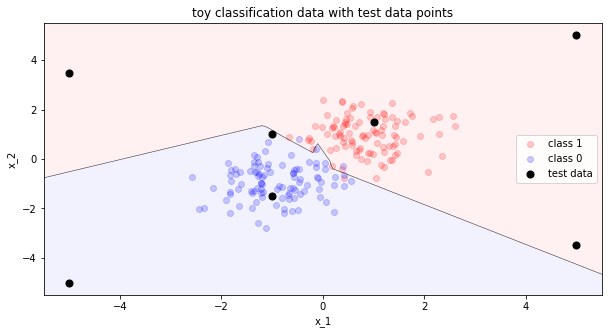

In [ ]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
ax.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class 0')
plot_decision_boundary(x_train, y_train, [nn], ax, poly_degree=1, test_points=test_points, shaded=True)
# for i in range(len(test_points)):
#     pt = test_points[i]
#     if i == 0:
#         ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
#     else:
#         ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()

In [ ]:
# Ensemble (more or less works, but gives the nan error )
N_bootsrap = 20 
# bootstrap the training data 
data = pd.DataFrame(pd.np.column_stack([x_train, y_train]))

w_bootstrap = []
nn_all = []
for n_idx in range(N_bootsrap): 
    data_bootstrap = data.sample(frac=1, replace=True)
    x_bootstrap = data_bootstrap[[0,1]].to_numpy() #.to_numpy()
    y_bootstrap = data_bootstrap[2].to_numpy()
    nn_here = Feedforward(architecture, random=random)
    nn_here.fit(x_bootstrap.T, y_bootstrap.reshape((1,-1)), params, reg_param = .001)
    w_bootstrap.append(nn.weights)
    nn_all.append(nn_here)
    print("Calculations done {}/{}".format(n_idx, N_bootsrap))


Iteration 9500 lower bound 0.014094710082455907; gradient mag: 0.0002677732730661576
Iteration 9600 lower bound 0.014076387994970295; gradient mag: 0.00031983943103739733
Iteration 9700 lower bound 0.014040718902507417; gradient mag: 0.00041450620035903636
Iteration 9800 lower bound 0.013986914123552643; gradient mag: 0.0004666958779686095
Iteration 9900 lower bound 0.01393152116824473; gradient mag: 0.00044008882486191574
Calculations done 6/20
Iteration 0 lower bound 0.23586867258833097; gradient mag: 0.21686510359482028
Iteration 100 lower bound 0.167114090645883; gradient mag: 0.19647468558809994
Iteration 200 lower bound 0.12779119918723547; gradient mag: 0.11754518881306178
Iteration 300 lower bound 0.0869724677120263; gradient mag: 0.11856691476302694
Iteration 400 lower bound 0.045003702702717266; gradient mag: 0.06735018649869158
Iteration 500 lower bound 0.031438131943400796; gradient mag: 0.03933916346668687
Iteration 600 lower bound 0.02590958673266396; gradient mag: 0.0266

KeyboardInterrupt: 

In [ ]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
ax.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class 0')
plot_decision_boundary(x_train, y_train, nn_all, ax, poly_degree=1, test_points=test_points, shaded=True)
# for i in range(len(test_points)):
#     pt = test_points[i]
#     if i == 0:
#         ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
#     else:
#         ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()

In [ ]:
n_samples=100 
x_moon, y_moon = make_moons(n_samples=n_samples, shuffle=True, noise=0.1, random_state=None)

In [ ]:
nn.forward(nn.weights, np.array([-2.0, -4.0]).reshape((2,1)))

array([[[0.0394472]]])

In [ ]:
###neural network model design choices
width = 10
hidden_layers = 1
input_dim = x_moon.shape[1]
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': activation_fn_type,
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

###define design choices in gradient descent
params = {'step_size':1e-2, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x_moon.T, y_moon.reshape((1,-1)), params,  reg_param = .001)

Iteration 0 lower bound 0.5021653316147979; gradient mag: 0.04321866611366177
Iteration 100 lower bound 0.07660364919031523; gradient mag: 0.029624177095337295
Iteration 200 lower bound 0.0438191272070469; gradient mag: 0.0173229665535604
Iteration 300 lower bound 0.027624421772131744; gradient mag: 0.009873687949991808
Iteration 400 lower bound 0.02164920988448282; gradient mag: 0.006137100867871152
Iteration 500 lower bound 0.018826286386555334; gradient mag: 0.004385367663166465
Iteration 600 lower bound 0.017216061750288475; gradient mag: 0.003108855633526825
Iteration 700 lower bound 0.01627811215277759; gradient mag: 0.002428504809004443
Iteration 800 lower bound 0.0156827252672281; gradient mag: 0.0021682837849950373
Iteration 900 lower bound 0.015281612006671866; gradient mag: 0.00177746932952795
Iteration 1000 lower bound 0.014998409027722655; gradient mag: 0.0014195552030529834
Iteration 1100 lower bound 0.014789399907042691; gradient mag: 0.0014659113930479862
Iteration 1200

In [ ]:
# make sure the dimension is 1 by D 
class Feedforward_Dropout:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params'],
                       'dropout_rate': architecture['dropout_rate']} 

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        #Generate random mask
        num_zero = int(self.D*self.params['dropout_rate'])
        rng = np.random.default_rng()
        mask = rng.binomial(n=1, p=1-self.params['dropout_rate'], size=(1,self.D))
        #mask = np.ones(self.D)
        #mask[rng.integers(low=0, high=self.D, size=num_zero)] = 0
        #mask = mask.reshape((1, self.D))
        weights = np.multiply(mask, weights)

        if len(x.shape) == 2:
            assert x.shape[0] == D_in 
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T

        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = 1/(np.exp(-(np.matmul(W, input) + b)) + 1)
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param):

        def objective(W, t):
            squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
            if reg_param is None:
                sum_error = np.sum(squared_error)
                return sum_error
            else:
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error

        return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):

        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [ ]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)
# activation_fn = lambda x: 1 / (1 + np.exp(-x))

###neural network model design choices
width = 6
hidden_layers = 2
input_dim = x_train.shape[1]
output_dim = 1

architecture_dropout = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'dropout_rate': 0.1,
               'activation_fn_type': activation_fn_type,
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)
nn_dropout = Feedforward_Dropout(architecture_dropout, random=random)

params = {'step_size':1e-3, 
          'max_iteration':10000, 
          'random_restarts':1}
#fit my neural network to minimize MSE on the given data
nn_dropout.fit(x_moon.T, y_moon.reshape((1,-1)), params, reg_param = .001)

Iteration 0 lower bound 0.29598498160111036; gradient mag: 0.2955004080190794
Iteration 100 lower bound 0.22472264861621027; gradient mag: 0.09996490352882254
Iteration 200 lower bound 0.22707589805874465; gradient mag: 0.14591495629778034
Iteration 300 lower bound 0.14954151257091935; gradient mag: 0.11220081333367031
Iteration 400 lower bound 0.10802554820711063; gradient mag: 0.07228643710457155
Iteration 500 lower bound 0.30258922094471463; gradient mag: 0.08697805168743922
Iteration 600 lower bound 0.1258832444615231; gradient mag: 0.1187314586218488
Iteration 700 lower bound 0.20961583051821123; gradient mag: 0.3541297751376614
Iteration 800 lower bound 0.16460475430311838; gradient mag: 0.07787308029487523
Iteration 900 lower bound 0.11223507893142809; gradient mag: 0.07610637081626494
Iteration 1000 lower bound 0.24473037469277517; gradient mag: 0.2965712620041485
Iteration 1100 lower bound 0.10232352160280805; gradient mag: 0.11539217608975288
Iteration 1200 lower bound 0.1007

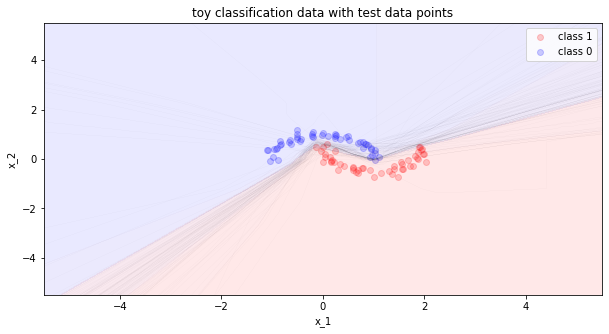

In [ ]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_moon[y_moon == 1, 0], x_moon[y_moon == 1, 1], alpha=0.2, c='red', label='class 1')
ax.scatter(x_moon[y_moon == 0, 0], x_moon[y_moon == 0, 1], alpha=0.2, c='blue', label='class 0')

plot_decision_boundary(x_moon, y_moon, [nn_dropout]*100, ax, poly_degree=1, test_points=None, shaded=True)
# for i in range(len(test_points)):
#     pt = test_points[i]
#     if i == 0:
#         ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
#     else:
#         ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

plt.show()

In [ ]:
n_samples=1000 
x_moon_test, y_moon_test = make_moons(n_samples=n_samples, shuffle=True, noise=0.1, random_state=None)

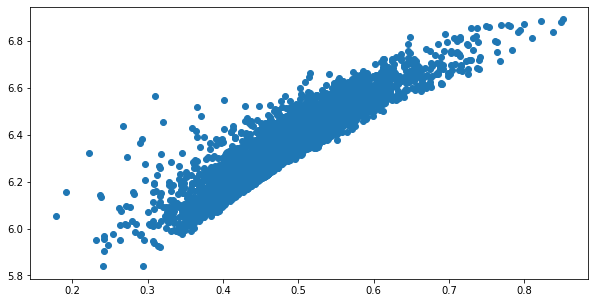

In [ ]:
# IGNORE THIS
# N = 5000
# p = []
# H_pred = []
# for i in range(N):
#     p_here = nn_dropout.forward(nn_dropout.weights, x_moon_test.reshape((2,n_samples)))
#     H_pred_here = sp.stats.entropy(p_here[0][0])
#     p.append(np.mean(p_here[0][0])) # should I take the mean here? 
#     H_pred.append(H_pred_here)
# p = np.array(p)
# H_pred = np.array(H_pred)

# # roughly agrees with Fig. 4b 
# fig,ax=plt.subplots(1,1,figsize=(10,5))
# ax.scatter(p,H_pred) # why is H_pred in the paper between 0 and 1? 
# plt.show()

In [ ]:
# calculate the accuracy for MC dropout
def auc_calc(x_test, y_test, nn, n_samples, N, perc): 

    '''
    n_samples is the number of test points

    p_mean and entropymean are lists of length n_samples
    '''
    
    p = []
    p_mean, entropymean = myentropy(nn, [nn.weights]*N, x_test.reshape((2, n_samples)))
    idx = np.argsort(entropymean)
    y_pred_retained = p_mean[idx[0:int(perc*n_samples)]] # choosing samples with smallest entropy to evaluate 
    y_test_retained = y_test[idx[0:int(perc*n_samples)]]
    auc = len(y_test_retained[np.round(y_pred_retained)==y_test_retained]) / len(y_pred_retained) * 100
    return auc

# calculate the accuracy for deterministic model
def auc_calc_proba(x_test, y_test, nn, n_samples, N, perc):
    auc = np.zeroes(N)
    for j in range(N):
        p_here = nn.forward(nn.weights, x_test)[0][0]
        idx = np.argsort(p_here[0][0])
        i2 = int((1-perc/2)*n_samples)
        i1 = int(perc*n_samples/2)
        idx1 = idx[0:i1] # indices predicted to be 0 
        idx2 = idx[i2:] # indices predicted to be 1 
        x0 = x_test[idx1]
        y0 = y_test[idx1]
        y1 = y_test[idx2]
        # print(len(y1[y1==1])+len(y0[y0==0]), len(y0)+len(y1), (len(y1[y1==1])+len(y0[y0==0]))/(n_samples*perc))
        auc[j] = (len(y0[y0==0]) + len(y1[y1==1]))/(len(y0) + len(y1))
    return auc

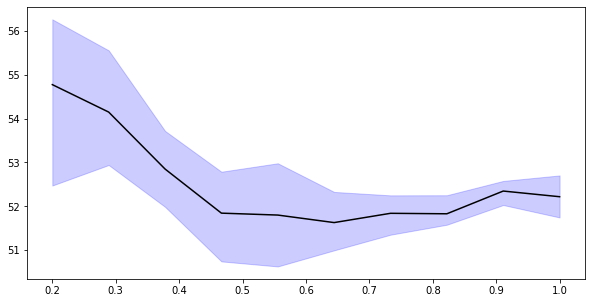

In [ ]:
# uncertainty metric
n_samples = 1000 
n_run = 100 # the number of times to call the NN for predictive entropy 
N = 20
x_moon_test, y_moon_test = make_moons(n_samples=n_samples, shuffle=True, noise=1, random_state=None)

retain_perc = np.linspace(0.2, 1, 10)
auc = np.zeros([len(retain_perc),N])
for (i, perc) in enumerate(retain_perc):
    for j in range(N):
        auc[i,j] = auc_calc(x_moon_test, y_moon_test, nn_dropout, n_samples, N, perc)

    # use sigmoid probability for data retainning
    
auc_ub = np.percentile(auc, 97.5, axis=1)
auc_lb = np.percentile(auc, 2.5, axis=1)

fig,ax=plt.subplots(1,1,figsize=(10,5))

ax.fill_between(retain_perc, auc_ub, auc_lb, color='blue', alpha=0.2)
ax.plot(retain_perc, np.mean(auc,axis=1), 'black')
plt.show()


In [ ]:
#Just trying something out

N = 5000

#wrapper

def myentropy(nn_model, weightlist, xdata):
    '''
    Usage: for NN_Dropout, use the same weights, duplicated N times
    for MFVI, pass the sampled weights
    '''

    #assert xdata.shape[0]==2
    n_samples = xdata.shape[1]
    p1narray = np.zeros((len(weightlist), n_samples))
    for i, w in enumerate(weightlist):
        p1narray[i, :] = nn_model.forward(w, xdata) #assumes that the 'model.forward' is dropout-like and has generates different outputs for each i
    #print (p_here.shape)
    p2narray = 1 - p1narray
    p1narray = np.mean(p1narray, axis=0)
    p2narray = np.mean(p2narray, axis=0)
    Hpredcheck = -p1narray*np.log(p1narray) - p2narray*np.log(p2narray)
    return p1narray, Hpredcheck

pmean, entropymean = myentropy(nn_dropout, [nn_dropout.weights]*500, x_moon_test.reshape((2, 1000)))
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.scatter(pmean, entropymean) # why is H_pred in the paper between 0 and 1? 
plt.show()

NameError: name 'nn_dropout' is not defined

In [ ]:
# NEED TO PLOT THE TRAINING DATA SEPARATELY!
def plot_entropycontours(x, y, model, weightlist, ax, title, poly_degree=1, test_points=None, shaded=True, interval=np.arange(-6, 6, 0.1)):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    # ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    # ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    #interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)
    print ('xx', xx.shape)
    # Predict on mesh points
    
    yy = myentropy(model, weightlist, xx.T)[1] #change this to entropy func  
    yy = yy.reshape((n, n))
    
    
    cl = plt.imshow(yy, origin='lower', extent=(min(interval), max(interval), min(interval), max(interval)))
    plt.colorbar()
    plt.title(title)
    plt.show()
    
    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
        
    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax


class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def predict(self, x):
        y = sigmoid(x.dot(self.slopes) + self.intercept)
        
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

xx (14400, 2)


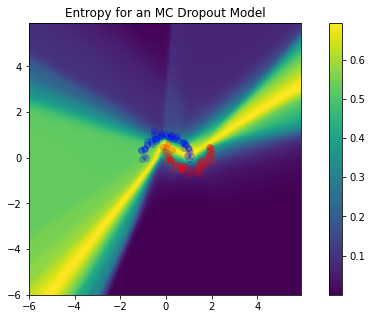

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_moon[y_moon == 1, 0], x_moon[y_moon == 1, 1], alpha=0.2, c='red', label='class 1')
ax.scatter(x_moon[y_moon == 0, 0], x_moon[y_moon == 0, 1], alpha=0.2, c='blue', label='class 0')

plot_entropycontours(x_train, y_train, nn_dropout, [nn_dropout.weights]*50, ax, 'Entropy for an MC Dropout Model', poly_degree=1, test_points=test_points, shaded=True)# for i in range(len(test_points)):
#     pt = test_points[i]
#     if i == 0:
#         ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
#     else:
#         ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

plt.show()


NameError: name 'posterior_samples' is not defined

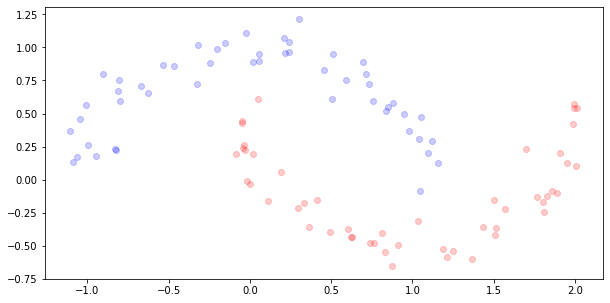

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_moon[y_moon == 1, 0], x_moon[y_moon == 1, 1], alpha=0.2, c='red', label='class 1')
ax.scatter(x_moon[y_moon == 0, 0], x_moon[y_moon == 0, 1], alpha=0.2, c='blue', label='class 0')

plot_entropycontours(x_train, y_train, nn, [posterior_samples[i].reshape((1, -1)) for i in range(posterior_samples.shape[0])], ax, 'Entropy for an MFVI Model', poly_degree=1, test_points=test_points, shaded=True)# for i in range(len(test_points)):
#     pt = test_points[i]
#     if i == 0:
#         ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
#     else:
#         ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

plt.show()


In [ ]:
def black_box_variational_inference(logprob, D, num_samples):
    
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        # unwrap the parameters, separate into mean and std 
        # optimize for log of variance to make sure it is positive
        # print ('Params=', params.shape)
        mean, log_std = params[:D], params[D:]
        return np.array(mean), np.array(log_std)

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        # print (rs.randn(num_samples, D).shape, np.exp(log_std).shape, mean.shape)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        #print ('Varnl', gaussian_entropy(log_std).shape, np.mean(logprob(samples, t).shape))
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t)) #here!
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

def variational_inference(Sigma_W, sigma_y, y_train, x_train, forward, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    
    # define the log prior on the model parameters (Gaussian)
    def log_prior(W):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        # print ('Prior Shape=', log_p_W.shape)
        return log_p_W
        

    # define the log likelihood
    def log_lklhd(W):
        W = W.reshape(S, D)
        # print (W.shape)
        p = np.squeeze(forward(W, x_train))
        # print("the size of p is ", p.shape, ", the size of y_train is ", y_train.shape)
        #print (x_train.shape, p.shape) #np.random.normal(0, 1, size=(2, 5))[:, np.array([2, 3])] works
        # y_train=y_train.flatten()
        lklh = np.zeros([S, p.shape[1]],dtype=float)
        # print('lklh shape is', lklh.shape)
        ind1 = np.where(y_train==0)[0]
        ind2 = np.where(y_train==1)[0]
        # print('ind1 and ind2, p, lklh shape', ind1.shape, ind2.shape, p[:, ind1].shape, lklh[:,ind1].shape)
        lklh = np.hstack((p[:,ind1],p[:,ind2]))
        # print('output lklhh shape is', np.sum(np.log(lklh),axis=1).shape)
        return np.sum(np.log(lklh),axis=1)

    # define the log joint density
    log_density = lambda w, t: log_prior(w) + log_lklhd(w) 

    # build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    # initialize variational parameters
    init_mean = np.reshape(nn_dropout.weights, nn_dropout.D) # !!!REMEMBER TO CHANGE THE nn_dropout WHEN WE RETRAIN A NEW NEURAL NETWORK!!!
    init_log_std = -10 * np.ones(D)
    #print ('Init', init_log_std.shape, D)
    init_var_params = np.concatenate([init_mean, init_log_std])
    
    # perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params 

In [ ]:
S = 20
max_iteration = 15000
step_size = 1e-3

Sigma_W = np.eye(nn_dropout.D)*25
sigma_y = 1

variational_params = variational_inference(Sigma_W, sigma_y, y_moon, x_moon.T, nn_dropout.forward, S, max_iteration, step_size, 1)

NameError: name 'nn_dropout' is not defined

In [ ]:
var_means = variational_params[0:nn_dropout.D]
var_variance = np.exp(variational_params[nn_dropout.D:])**2


data_test = make_moons(100)
x_test = data_test[0]
print(x_test.shape, x_moon.shape)
posterior_sample_size = 200
posterior_samples = np.random.multivariate_normal(var_means, np.diag(var_variance), size=posterior_sample_size)
print(posterior_samples.shape)
y_predict_noiseless = nn_dropout.forward(posterior_samples, x_test.T) #CHECK: Why are we doing the forward through the DROPOUT model?
y_predict_noiseless = np.squeeze(y_predict_noiseless)
print (y_predict_noiseless.shape)

(100, 2) (100, 2)
(200, 67)
(200, 100)


/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: No contour levels were found within the data range.


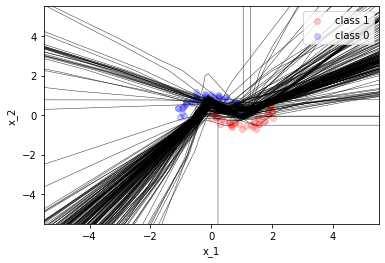

In [ ]:
fig,ax = plt.subplots(1,1)
ax.scatter(x_moon[y_moon == 1, 0], x_moon[y_moon == 1, 1], alpha=0.2, c='red', label='class 1')
ax.scatter(x_moon[y_moon == 0, 0], x_moon[y_moon == 0, 1], alpha=0.2, c='blue', label='class 0')
for i in range(posterior_sample_size):
    plot_decision_boundary(x_test, y_predict_noiseless[i,:], [nn_dropout], ax, poly_degree=1, test_points=None, shaded=False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_moon[y_moon == 1, 0], x_moon[y_moon == 1, 1], alpha=0.2, c='red', label='class 1')
ax.scatter(x_moon[y_moon == 0, 0], x_moon[y_moon == 0, 1], alpha=0.2, c='blue', label='class 0')

plot_entropycontours(x_train, y_train, [nn_dropout], ax, 'Entropy for an MC Dropout Model', poly_degree=1, test_points=test_points, shaded=True)# for i in range(len(test_points)):
#     pt = test_points[i]
#     if i == 0:
#         ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
#     else:
#         ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

plt.show()


In [ ]:

print(p.shape)
nn_dropout.weights.shape

In [ ]:
p=nn_dropout.forward(nn_dropout.weights, x_moon.T)
print(p.shape)
p=p.flatten()
p[y_moon==0]
p_multi = np.zeros([20, len(p)])
for i in range(20): 
    p_multi[i,:]=p
print(p_multi.shape)


lklh = np.zeros([20, len(y_moon)])
print('lklh is shape', lklh.shape)
ind = np.where(y_moon==0)[0]
lklh[:,ind] = p_multi[:,ind]
lklh[:,ind] = 1-p_multi[:,ind]

In [ ]:
print(np.where(y_train==0))

In [ ]:
posterior_samples.shape

(200, 67)

In [ ]:
import multiprocessing as mp


#https://stackoverflow.com/questions/10797998/is-it-possible-to-multiprocess-a-function-that-returns-something-in-python


def calculate(func, args):
    result = func(*args)
    return '%s says that %s%s = %s' % \
        (current_process().name, func.__name__, args, result)

def worker(input, output):
    for func, args in iter(input.get, 'STOP'):
        result = calculate(func, args)
        output.put(result)

def test():
    NUMBER_OF_PROCESSES = 4
    TASKS1 = [(nn_train, ()) for i in range(20)] #write nn_train function (or use nn.fit), the bracket should have the args to the nn_train func

    # Create queues
    task_queue = Queue()
    done_queue = Queue()

    # Submit tasks
    for task in TASKS1:
        task_queue.put(task)

    # Start worker processes
    for i in range(NUMBER_OF_PROCESSES):
        Process(target=worker, args=(task_queue, done_queue)).start()

    # Get and print results
    print 'Unordered results:'
    de_weights = []
    for i in range(len(TASKS1)):
        de_weights.append(done_queue.get())


In [ ]:
#Trying to wrap Deep Ensembles with multiprocessing
N_bootsrap = 20 
# bootstrap the training data 
data = pd.DataFrame(pd.np.column_stack([x_train, y_train]))

w_bootstrap = []
nn_all = []

for n_idx in range(N_bootsrap): 
    data_bootstrap = data.sample(frac=1, replace=True)
    x_bootstrap = data_bootstrap[[0,1]].to_numpy() #.to_numpy()
    y_bootstrap = data_bootstrap[2].to_numpy()
    nn_here = Feedforward(architecture, random=random)
    nn_here.fit(x_bootstrap.T, y_bootstrap.reshape((1,-1)), params, reg_param = .001)
    w_bootstrap.append(nn.weights)
    nn_all.append(nn_here)
    print("Calculations done {}/{}".format(n_idx, N_bootsrap))
